# 1. Library importation

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install json-tricks

In [ ]:
%%capture
import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

#2. Audio file preprocessing


In [ ]:
import os
import matplotlib.pyplot as plt

#for loading and visualizing audio files
import librosa
import librosa.display


#to play audio
import IPython.display as ipd

## 2.1 CNN+LSTM preprocessing(no need to run now)

In [ ]:
# create spectrogram image from audio file
def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)
    
#  using create_spectrogram function to convert audio file to image
def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_spectrogram(input_file, output_file)

## 2.2 Emotion labeling

In [ ]:
def find_emotion_T(name): 
        if('neutral' in name): return 0
        elif('happy' in name): return 1
        elif('sad' in name): return 2
        elif('angry' in name): return 3
        elif('fear' in name): return 4
        elif('disgust' in name): return 5
        elif('ps' in name): return 6
        else: return -1

##2.3 Load the spectrgram image and label the image

In [ ]:
import numpy as np
import librosa.display, os
import matplotlib.pyplot as plt
import cv2

images = []
emotions = []
folder_path = '/content/drive/MyDrive/deep_learning/Speech_Emotion_Recognition/SPEC/' 

for subdir, dirs, files in os.walk(folder_path):
  i = 0
  for file in files: 
    # load all images will cause the ram overload and crash.
    i += 1
    if(i> 200): break

    path = os.path.join(subdir,file)
    img = cv2.imread(path)
    images.append(img)

    name = find_emotion_T(file)
    emotions.append(name) 

#3. Data setup

In [ ]:
f_images = np.asarray(images).astype('float32')
X = np.transpose(f_images, (0, 3, 1, 2))
print(f_images.shape)

(1400, 288, 432, 3)


In [ ]:
# expand y to 2 dimension
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)
print(Y.shape)

(1400, 1)


In [ ]:
# Shuffle the data
from sklearn.utils import shuffle
for i in range(10):
    X, Y = shuffle(X, Y, random_state=i)

## 3.1  Split train, val, test data and convert y to one hot vector

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.2, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.4, random_state = 1)

y_train_class = tf.keras.utils.to_categorical(y_train, 7, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 7, dtype = 'int8')

In [ ]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(1120, 3, 288, 432)
(168, 3, 288, 432)
(112, 3, 288, 432)


##3.2 Save the test data

In [ ]:
# Save X,Y arrays as lists to json files.

x_test_data = x_test.tolist() 
x_test_path = 'drive/MyDrive/deep_learning/Speech_Emotion_Recognition/data_set/cnn_lstm_x_test.json' # FILE SAVE PATH
dump(obj = x_test_data, fp = x_test_path)

y_test_data = y_test.tolist() 
y_test_path = 'drive/MyDrive/deep_learning/Speech_Emotion_Recognition/data_set/cnn_lstm_y_test.json' # FILE SAVE PATH
dump(obj = y_test_data, fp = y_test_path)


'[[4], [0], [1], [6], [1], [2], [4], [0], [1], [1], [0], [1], [6], [6], [1], [1], [4], [6], [1], [5], [2], [2], [4], [6], [0], [4], [0], [4], [3], [3], [1], [5], [2], [2], [6], [6], [0], [6], [4], [4], [1], [0], [4], [1], [6], [5], [4], [6], [4], [2], [5], [6], [5], [6], [4], [3], [2], [2], [5], [3], [6], [5], [6], [4], [0], [0], [0], [2], [6], [0], [4], [4], [3], [1], [0], [4], [3], [1], [1], [0], [1], [4], [4], [2], [6], [4], [3], [1], [5], [0], [4], [3], [6], [3], [0], [6], [6], [4], [3], [1], [2], [2], [3], [0], [3], [6], [5], [0], [2], [4], [0], [2]]'

#4 Model training

In [ ]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks 

from tensorflow.keras.layers import LSTM as KERAS_LSTM
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, \
    Activation, BatchNormalization, MaxPooling2D

In [ ]:
# Initializing the model
model = Sequential()
model.add(Conv2D(
              filters = 32,
              kernel_size = 2,
              padding = 'same',
              input_shape = X.shape[1:4]))  # conv layer
model.add(MaxPooling2D(2,2))
model.add(tf.keras.layers.Reshape((144, 32), input_shape=(1, 144, 32)))

model.add(layers.LSTM(64)) # lstm layer
model.add(Dense(64, activation='relu')) 
model.add(Dense(7, activation='softmax')) 
print(model.summary())

batch_size = 23

# Callbacks functions
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/best_weights.hdf5'

# Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')                 
# Compile & train   
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class, 
                      epochs=50, batch_size = batch_size, 
                      validation_data = (x_val, y_val_class), 
                      callbacks = [mcp_save])
# Define the best weights to the model.
model.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 3, 288, 32)        55328     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 144, 32)       0         
 )                                                               
                                                                 
 reshape (Reshape)           (None, 144, 32)           0         
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                        

#5. MODEL EVALUATION

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

## 5.1 Accuracy and loss over epoches for train and val dataset

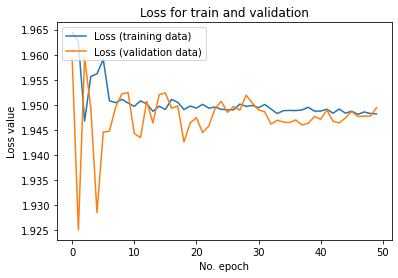

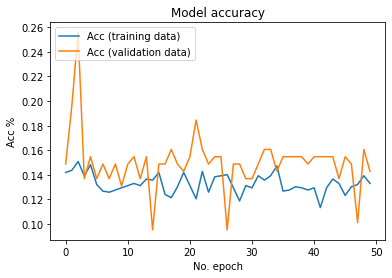

In [ ]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## 5.2 Save & Load model, weights


In [ ]:
# Saving model & weights

from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
saved_model_path = '/content/drive/MyDrive/deep_learning/Speech_Emotion_Recognition/Model_weights/cnn_lstm_model.json'
saved_weights_path = '/content/drive/MyDrive/deep_learning/Speech_Emotion_Recognition/Model_weights/cnn_lstm_weights.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)
    
model.save_weights(saved_weights_path)
print("Saved model to disk")


Saved model to disk


#6.  Test dataset evaluation

In [ ]:
!pip install json-tricks

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd
from json_tricks import load

import numpy as np
import os

## 6.1 Load the model and test data.

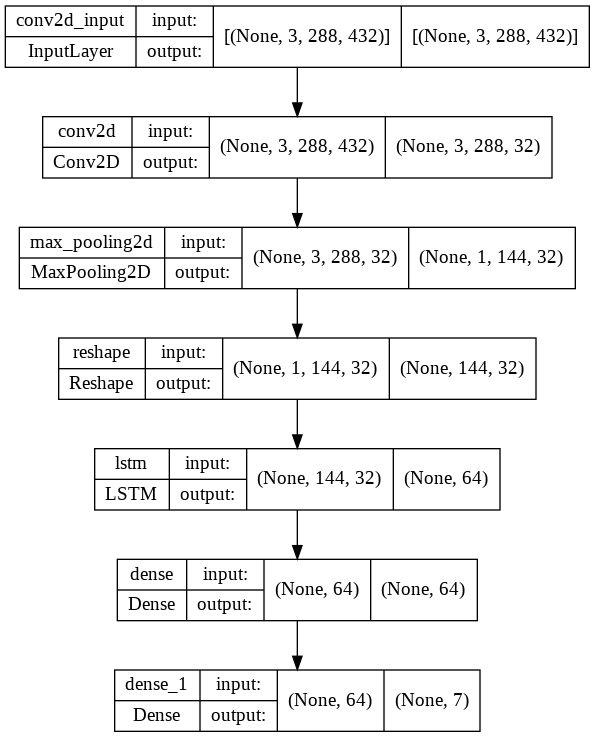

In [ ]:
# Reading the model from JSON file

saved_model_path = '/content/drive/MyDrive/deep_learning/Speech_Emotion_Recognition/Model_weights/cnn_lstm_model.json'
saved_weights_path = '/content/drive/MyDrive/deep_learning/Speech_Emotion_Recognition/Model_weights/cnn_lstm_weights.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()

# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Loading x_test, y_test json files, and converting to np.arrays

x_test = load( 'drive/MyDrive/deep_learning/Speech_Emotion_Recognition/data_set/cnn_x_test.json')
x_test = np.asarray(x_test).astype('float32')

y_test = load('drive/MyDrive/deep_learning/Speech_Emotion_Recognition/data_set/cnn_y_test.json')
y_test = np.asarray(y_test).astype('int8')
print(y_test.shape)

(112, 1)


## 6.2 Test Set Evaluation

**Test Set Score**

In [ ]:
y_test_class = tf.keras.utils.to_categorical(y_test, 7, dtype = 'int8')
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

4/4 - 2s - loss: 2.0200 - categorical_accuracy: 0.1786 - 2s/epoch - 390ms/step


**Test Set Confussion Matrix**

Text(0.5, 50.09375, 'Predicted emotion')

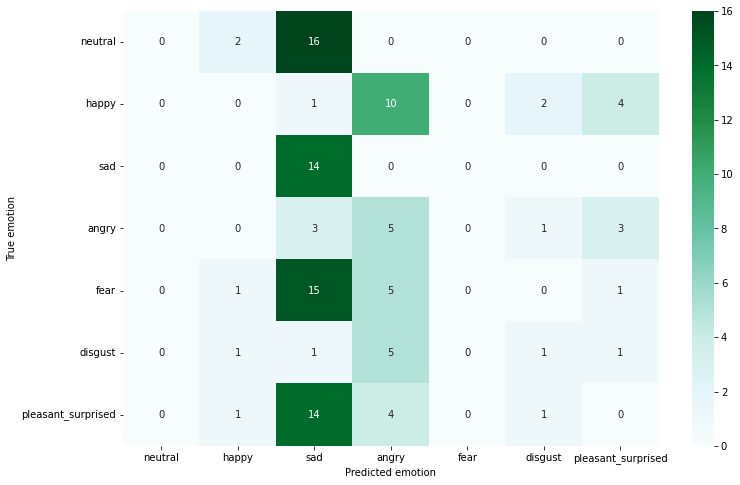

In [ ]:
# Test set Confusion matrix
y_test_class = tf.keras.utils.to_categorical(y_test, 7, dtype = 'int8')
y_test_class = np.argmax(y_test_class, axis=1)
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)
 
index = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust', 'pleasant_surprised'] 

cm_df = pd.DataFrame(cm,index, index)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

**Test Set Predicted emotions accuracy**

In [ ]:
# Test set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
neutral : 0.0000
happy : 0.0000
sad : 1.0000
angry : 0.4167
fear : 0.0000
disgust : 0.1111
pleasant_surprised : 0.0000
